# Problem 1: Weather Classification
The plan for this section is to:
* Explore weather dataset.
* Engineer helpful features.
* Preprocessing data.
* Set up several models, including neural networks, for classifying weather (sun, rain, snow, drizzle) and compare performance.

## Data Exploration
Goal: To identify the basic features, their datatypes, and present visual relationships in the data.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

weather_df = pd.read_csv('/content/drive/MyDrive/info_4604/final project/seattle-weather.csv')
weather_df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [19]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [20]:
weather_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,1461,1461,2015-12-31,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precipitation,1461.0,NaN,NaN,NaN,3.029432,6.680194,0.0,0.0,0.0,2.8,55.9
temp_max,1461.0,NaN,NaN,NaN,16.439083,7.349758,-1.6,10.6,15.6,22.2,35.6
temp_min,1461.0,NaN,NaN,NaN,8.234771,5.023004,-7.1,4.4,8.3,12.2,18.3
wind,1461.0,NaN,NaN,NaN,3.241136,1.437825,0.4,2.2,3.0,4.0,9.5
weather,1461,5,rain,641,NaN,NaN,NaN,NaN,NaN,NaN,NaN


At first glance, it appears that the basic features are:
* Date (YYYY-MM-DD)
* Precipitation (mm)
* temp max/min (C)
* wind (m/s)
* weather (target category)

The date is useful for time-series analysis as all of our data points are ordered by the time at which they occur. Therefore, the date should converted from a string to a datetime object and set as the index in order to view the trends in numerical data over time.

In [21]:
weather_df['date'] = pd.to_datetime(weather_df['date'])

In [22]:
weather_df.set_index('date', inplace=True)

In [23]:
weather_df.head()

,precipitation,temp_max,temp_min,wind,weather
date,,,,,
2012-01-01,0.0,12.8,5.0,4.7,drizzle
2012-01-02,10.9,10.6,2.8,4.5,rain
2012-01-03,0.8,11.7,7.2,2.3,rain
2012-01-04,20.3,12.2,5.6,4.7,rain
2012-01-05,1.3,8.9,2.8,6.1,rain


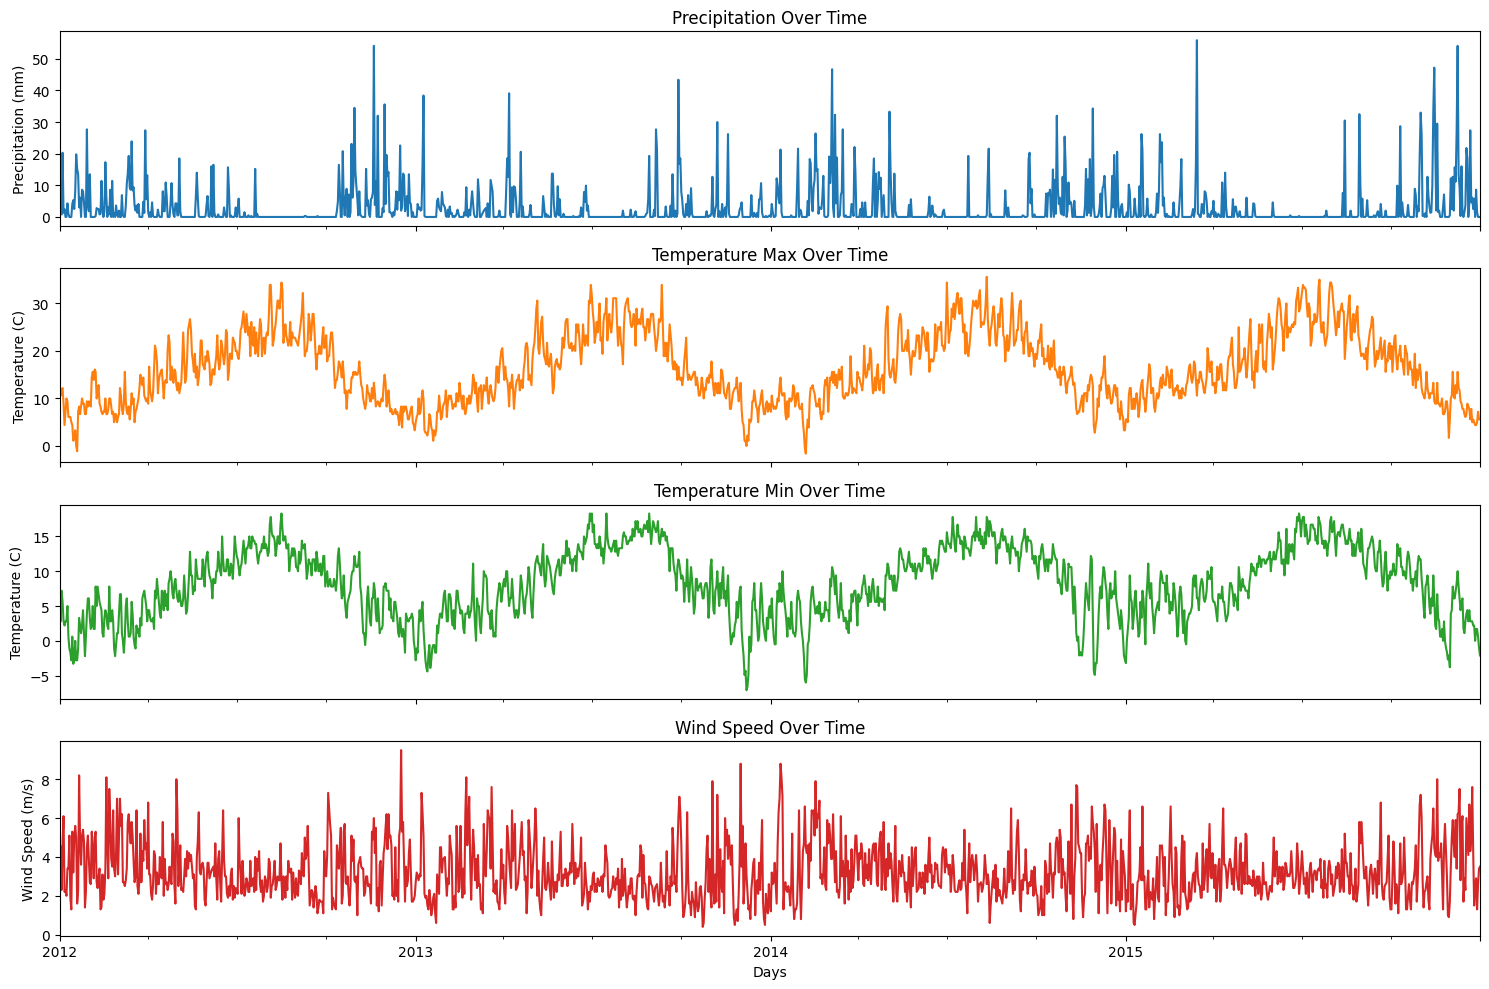

In [24]:
axes = weather_df.plot(
    subplots=True,
    figsize=(15, 10),
    legend=False,
)

axes[0].set_title('Precipitation Over Time')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Precipitation (mm)')

axes[1].set_title('Temperature Max Over Time')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Temperature (C)')

axes[2].set_title('Temperature Min Over Time')
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Temperature (C)')

axes[3].set_title('Wind Speed Over Time')
axes[3].set_xlabel('Days')
axes[3].set_ylabel('Wind Speed (m/s)')

plt.tight_layout()
plt.show()

Since the target variable is a set of discrete categories, a countplot will give a good idea of the distribution of target variables.

/tmp/ipython-input-4165377963.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=weather_df, x='weather', palette='viridis')


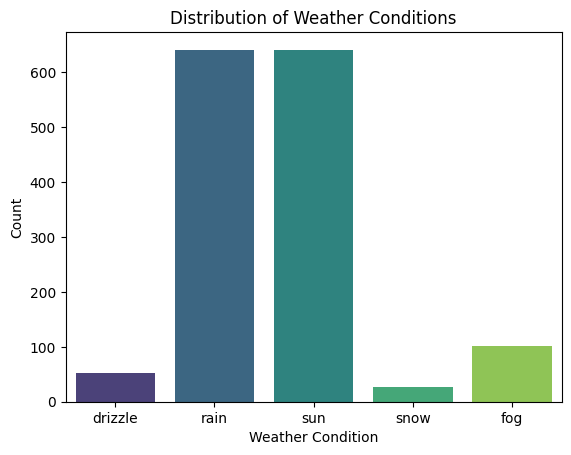

In [25]:
sns.countplot(data=weather_df, x='weather', palette='viridis')
plt.title('Distribution of Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Count')
plt.show()

Since the target data is very imbalanced, many models might struggle to handle predictions for uncommon categories (drizzle and snow). Balanced class weights for each model are likely the best strategy in this case.

## Feature Engineering
Goal: To create informative features based on weather-science and known information about the dataset.

In [26]:
# AI disclaimer: asked chatgpt to come up with some useful features to add to the data

# seasonal information
weather_df['month'] = weather_df.index.month
weather_df['day_of_year'] = weather_df.index.dayofyear
weather_df['sin(day_of_year)'] = np.sin(2 * np.pi * weather_df['day_of_year'] / 365)
weather_df['cos(day_of_year)'] = np.cos(2 * np.pi * weather_df['day_of_year'] / 365)

# weather-science information
weather_df['temp_diff'] = weather_df['temp_max'] - weather_df['temp_min']
weather_df['is_freezing'] = weather_df['temp_min'] <= 0
weather_df['is_hot'] = weather_df['temp_max'] >= 30
weather_df['windiness'] = pd.cut(
    weather_df['wind'],
    bins=[0, 3, 6, 9, np.inf],
    labels=['low', 'medium', 'high', 'very high'])
weather_df['rainfall'] = pd.cut(
    weather_df['precipitation'],
    bins=[-1, 0, 2, 20, np.inf],
    labels=['none', 'light', 'moderate', 'heavy']
)

weather_df.head()

,precipitation,temp_max,temp_min,wind,weather,month,day_of_year,sin(day_of_year),cos(day_of_year),temp_diff,is_freezing,is_hot,windiness,rainfall
date,,,,,,,,,,,,,,
2012-01-01,0.0,12.8,5.0,4.7,drizzle,1,1,0.017213,0.999852,7.8,False,False,medium,none
2012-01-02,10.9,10.6,2.8,4.5,rain,1,2,0.034422,0.999407,7.8,False,False,medium,moderate
2012-01-03,0.8,11.7,7.2,2.3,rain,1,3,0.051620,0.998667,4.5,False,False,low,light
2012-01-04,20.3,12.2,5.6,4.7,rain,1,4,0.068802,0.997630,6.6,False,False,medium,heavy
2012-01-05,1.3,8.9,2.8,6.1,rain,1,5,0.085965,0.996298,6.1,False,False,high,light


In [27]:
weather_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
precipitation,1461.0,NaN,NaN,NaN,3.029432,6.680194,0.0,0.0,0.0,2.8,55.9
temp_max,1461.0,NaN,NaN,NaN,16.439083,7.349758,-1.6,10.6,15.6,22.2,35.6
temp_min,1461.0,NaN,NaN,NaN,8.234771,5.023004,-7.1,4.4,8.3,12.2,18.3
wind,1461.0,NaN,NaN,NaN,3.241136,1.437825,0.4,2.2,3.0,4.0,9.5
weather,1461,5,rain,641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,1461.0,NaN,NaN,NaN,6.52293,3.449884,1.0,4.0,7.0,10.0,12.0
day_of_year,1461.0,NaN,NaN,NaN,183.125257,105.474746,1.0,92.0,183.0,274.0,366.0
sin(day_of_year),1461.0,NaN,NaN,NaN,0.000012,0.707107,-0.999991,-0.705584,0.0,0.705584,0.999991
cos(day_of_year),1461.0,NaN,NaN,NaN,0.000684,0.70759,-0.999963,-0.708627,0.004304,0.702527,1.0
temp_diff,1461.0,NaN,NaN,NaN,8.204312,3.82002,0.6,5.5,7.7,10.6,18.9


Summary of new features:
* month: numerical feature that may be useful for identifying gross seasonal trends
* day_of_year: numerical feature that may be useful for identifying fine seasonal trends
* sin & cos: converts day_of_year to a sinusoidal function which may help the model understand seasonal trends more accurately.
* temp_diff: differences between the high and low temperature may give some insight on weather such as fog.
* is_freezing: may be helpful in identifying differences in conditions that allow for snow vs. rain.
* is_hot: also may be helpful for identifying certain weather.
* windiness: creates a categorical feature based on numerical wind speed.
* rainfall: creates a categorical feature based on numerical precipitation.

A correllation matrix and ANOVA values will be useful for seeing relationships between all the new categorical features, while Chi2 test will be useful for seeing which categorical variables correlate the most.

In [28]:
num_cols = ['precipitation', 'temp_max', 'temp_min', 'wind', 'day_of_year', 'sin(day_of_year)', 'cos(day_of_year)', 'temp_diff']
cat_cols = ['month', 'is_freezing', 'is_hot', 'windiness', 'rainfall']

X = weather_df[num_cols + cat_cols]
y = weather_df['weather']

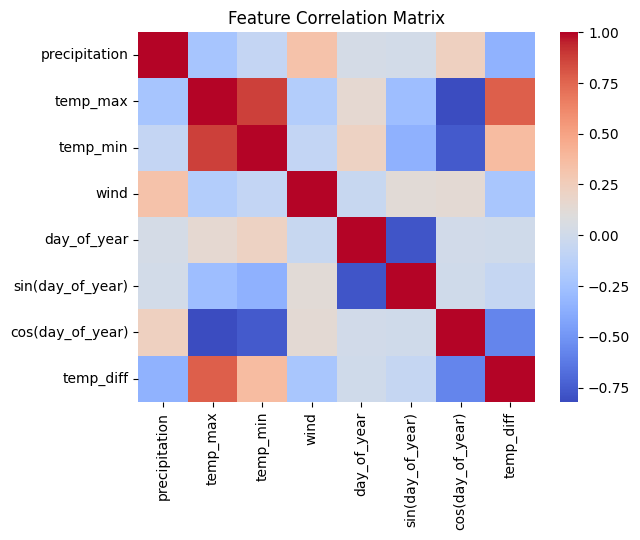

In [29]:
# Features correlation matrix
sns.heatmap(weather_df[num_cols].corr(), cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

,Feature,F-value,p-value
7,temp_diff,185.231665,2.145903e-128
0,precipitation,119.086023,5.866414e-88
1,temp_max,94.838655,9.411575e-72
6,cos(day_of_year),60.047741,5.511528e-47
3,wind,40.779274,1.986750e-32
2,temp_min,30.281944,3.087443e-24
5,sin(day_of_year),8.291443,1.302611e-06
4,day_of_year,2.918478,2.027934e-02


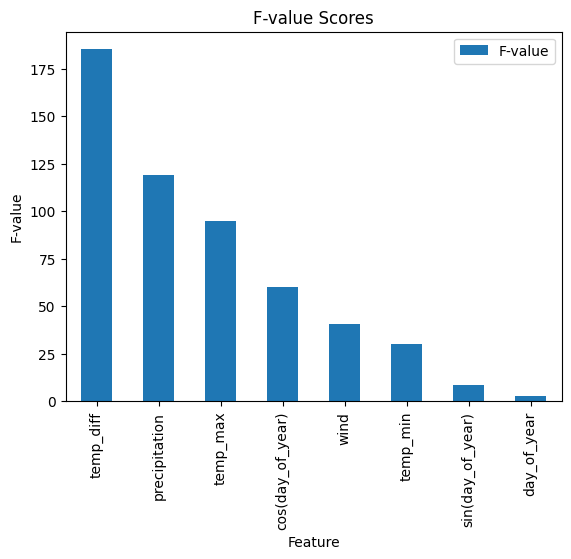

In [30]:
from sklearn.feature_selection import f_classif
f_values, p_values = f_classif(weather_df[num_cols], y)

scores_df = pd.DataFrame({
    'Feature': num_cols,
    'F-value': f_values,
    'p-value': p_values
})
scores_df = scores_df.sort_values(by='F-value', ascending=False)
display(scores_df)

scores_df.plot(x='Feature', y='F-value', kind='bar', title='F-value Scores')
plt.xlabel('Feature')
plt.ylabel('F-value')
plt.title('F-value Scores')
plt.show()

,Feature,Chi2 Score,p-value
7,rainfall_moderate,417.964719,3.650038e-89
6,rainfall_light,276.277350,1.414437e-58
1,is_freezing,113.940406,1.050413e-23
2,is_hot,63.098733,6.468845e-13
8,rainfall_heavy,60.710810,2.056495e-12
3,windiness_medium,38.598481,8.431915e-08
4,windiness_high,35.765101,3.234205e-07
0,month,23.823364,8.665726e-05
5,windiness_very high,1.279251,8.648859e-01


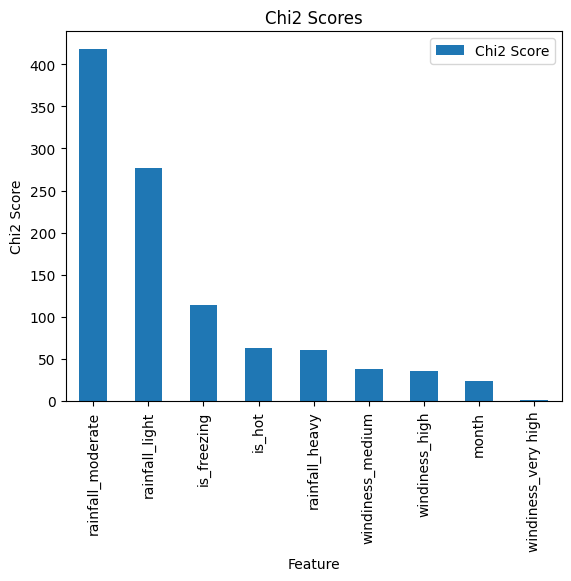

In [31]:
from sklearn.feature_selection import chi2
x_cat_encoded = pd.get_dummies(weather_df[cat_cols], drop_first=True)
chi2_scores, p_values = chi2(x_cat_encoded, y)

chi2_results = pd.DataFrame({
    'Feature': x_cat_encoded.columns,
    'Chi2 Score': chi2_scores,
    'p-value': p_values
}).sort_values(by='Chi2 Score', ascending=False)
display(chi2_results)
chi2_results = chi2_results.sort_values(by='Chi2 Score', ascending=False)
chi2_results.plot(x='Feature', y='Chi2 Score', kind='bar', title='Chi2 Scores')
plt.xlabel('Feature')
plt.ylabel('Chi2 Score')
plt.title('Chi2 Scores')
plt.show()

The most informative numerical features are:
1. temp_diff
2. precipitation
3. temp_max
4. cos(day_of_year)

The most informative categorical features are:
1. rainfall=moderate
2. rainfall=light
3. is_freezing
4. is_hot

Obviously knowing amounts of precipiation is one of the most useful predictors, as this would be the main distinguisher between rain and sun, the two most common weather categories. Interestingly temp diff is the most useful numerical feature.

In [32]:
# save new features into new file
num_cols = ['temp_diff', 'precipitation', 'temp_max', 'cos(day_of_year)']
cat_cols = ['rainfall', 'is_freezing', 'is_hot']

weather_df.to_csv('/content/drive/MyDrive/info_4604/final project/weather_features.csv')

## Preprocessing
Goal: develop the preprocessing strategy and convert data to a format that will be useable by the models.

In [33]:
# reload complete dataset
weather_df = pd.read_csv('/content/drive/MyDrive/info_4604/final project/weather_features.csv')
weather_df.set_index('date', inplace=True)
weather_df.head()

X = weather_df.drop(columns=['weather'])
y = weather_df['weather']

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

num_cols = ['temp_diff', 'precipitation', 'temp_max', 'cos(day_of_year)']
cat_cols = ['rainfall', 'is_freezing', 'is_hot']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

X = preprocess.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

onehot_encoder = OneHotEncoder()
y_train_encoded = onehot_encoder.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_test_encoded = onehot_encoder.transform(y_test.values.reshape(-1, 1)).toarray()

## Model Training & Testing
Goal: set up several classification models and fit them to training data. Compare model performance using metrics like accuracy, precision, recall, and F1 scores.

In [35]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np


models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        multi_class='multinomial',
        solver='lbfgs',
        class_weight='balanced'
    ),
    'Ridge Classifier': RidgeClassifier(
        alpha=1.0,
        random_state=42,
        class_weight='balanced'
    ),
    'Decision Tree': DecisionTreeClassifier(
        criterion='entropy',
        max_depth=5,
        class_weight='balanced',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42,
        class_weight='balanced'
    ),
    'Support Vector Machine (Linear)': SVC(
        kernel='linear',
        C=1.0,
        random_state=42,
        class_weight='balanced'
    ),
    'Support Vector Machine (RBF)': SVC(
        kernel='rbf',
        C=1.0,
        random_state=42,
        class_weight='balanced'
    ),
    'Support Vector Machine (Polynomial)': SVC(
        kernel='poly',
        C=1.0,
        random_state=42,
        class_weight='balanced'
    ),
}

shallow_nn = Sequential([
    Flatten(input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

shallow_nn.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Use categorical_crossentropy for one-hot encoded labels
    metrics=['accuracy']
)

deep_nn = Sequential([
    Flatten(input_shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

deep_nn.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Use categorical_crossentropy for one-hot encoded labels
    metrics=['accuracy']
)

models['Shallow Neural Network'] = shallow_nn
models['Deep Neural Network'] = deep_nn

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
# Helper function to plot accuracy and loss
def plot_training(history):
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Accuracy')
    plt.legend()
    plt.title('Training Progress')
    plt.grid(True)
    plt.show()

Training Logistic Regression...
Logistic Regression F1-Weighted: 0.6552901023890785
              precision    recall  f1-score   support

     drizzle       0.12      0.33      0.17         9
         fog       0.24      0.68      0.36        25
        rain       0.99      0.82      0.89       120
        snow       0.33      0.88      0.48         8
         sun       0.87      0.51      0.64       131

    accuracy                           0.66       293
   macro avg       0.51      0.64      0.51       293
weighted avg       0.83      0.66      0.70       293

Training Ridge Classifier...
Ridge Classifier F1-Weighted: 0.590443686006826
              precision    recall  f1-score   support

     drizzle       0.12      0.33      0.18         9
         fog       0.23      0.68      0.35        25
        rain       0.95      0.68      0.80       120
        snow       0.12      0.50      0.19         8
         sun       0.88      0.51      0.65       131

    accuracy            

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Random Forest F1-Weighted: 0.7713310580204779
              precision    recall  f1-score   support

     drizzle       0.33      0.11      0.17         9
         fog       0.30      0.72      0.42        25
        rain       0.95      0.91      0.93       120
        snow       0.40      0.25      0.31         8
         sun       0.87      0.73      0.80       131

    accuracy                           0.77       293
   macro avg       0.57      0.54      0.52       293
weighted avg       0.83      0.77      0.79       293

Training Support Vector Machine (Linear)...
Support Vector Machine (Linear) F1-Weighted: 0.6860068259385665
              precision    recall  f1-score   support

     drizzle       0.11      0.22      0.15         9
         fog       0.26      0.68      0.38        25
        rain       1.00      0.80      0.89       120
        snow       0.33      1.00      0.50         8
         sun       0.87      0.60      0.71       131

    accuracy                   

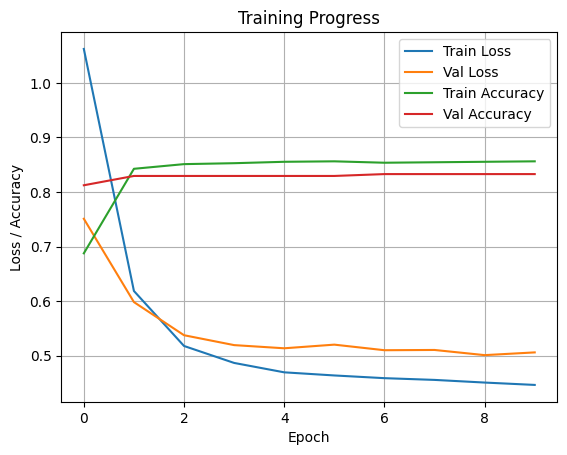

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Shallow Neural Network F1-Weighted: 0.8327645051194539
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00         9
         fog       0.00      0.00      0.00        25
        rain       0.95      0.93      0.94       120
        snow       0.67      0.25      0.36         8
         sun       0.76      1.00      0.86       131

    accuracy                           0.83       293
   macro avg       0.47      0.43      0.43       293
weighted avg       0.75      0.83      0.78       293

Training Deep Neural Network...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6485 - loss: 1.1298 - val_accuracy: 0.8294 - val_loss: 0.5986
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8446 - loss: 0.5474 - val_accuracy: 0.8294 - val_loss: 0.5682
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8581 - loss: 0.4857 - val_accuracy: 0.8294 - val_loss: 0.5260
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8587 - loss: 0.4578 - val_accuracy: 0.8294 - val_loss: 0.5366
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8545 - loss: 0.4519 - val_accuracy: 0.8294 - val_loss: 0.5222
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8477 - loss: 0.4549 - val_accuracy: 0.8328 - val_loss: 0.5230
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8525 - loss: 0.4613 - val_accuracy: 0.8328 - val_loss: 0.5132
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8644 - loss: 0.4265 - val_accuracy: 0.8328 - val_loss: 0.5004
Ep

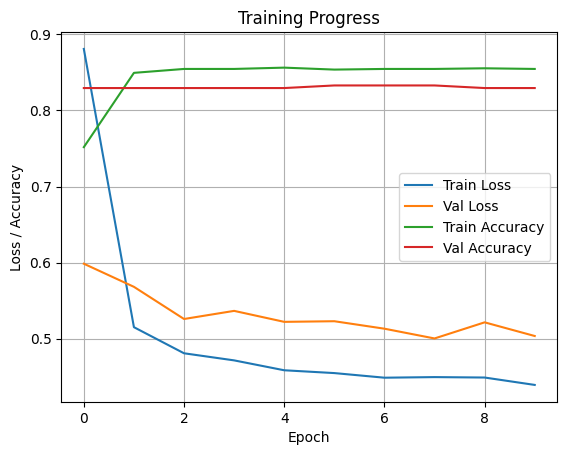

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Deep Neural Network F1-Weighted: 0.8293515358361775
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00         9
         fog       0.33      0.04      0.07        25
        rain       0.95      0.93      0.94       120
        snow       0.67      0.25      0.36         8
         sun       0.76      0.98      0.86       131

    accuracy                           0.83       293
   macro avg       0.54      0.44      0.45       293
weighted avg       0.77      0.83      0.78       293



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score


for model_name, model in models.items():
    print(f"Training {model_name}...")
    if model_name in ['Shallow Neural Network', 'Deep Neural Network']:
        y_train_encoded = onehot_encoder.fit_transform(y_train.values.reshape(-1, 1),).toarray()

        # code generated from chatGPT to ensure that class weights are balanced for neural networks
        classes = np.unique(y_train)
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
        class_weight_dict = dict(zip(classes, class_weights))

        history = model.fit(
            X_train,
            y_train_encoded,
            epochs=10,
            batch_size=32,
            validation_data=(X_test, y_test_encoded),
            class_weight=class_weight_dict
        )
        plot_training(history)
        y_pred_encoded = model.predict(X_test)
        y_pred = onehot_encoder.inverse_transform(y_pred_encoded)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{model_name} F1-Weighted: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))


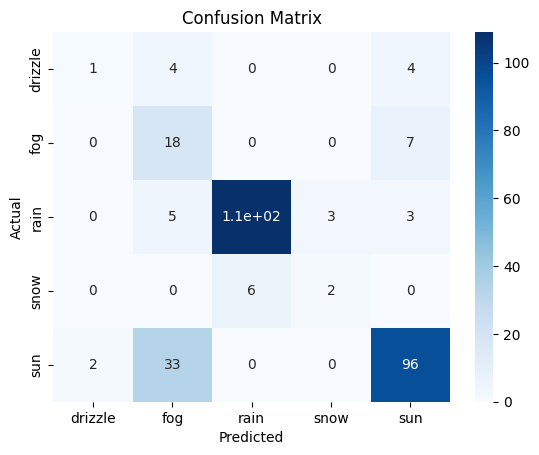

In [43]:
best_model = models['Random Forest']
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    cmap='Blues',
    xticklabels=['drizzle', 'fog', 'rain', 'snow', 'sun'],
    yticklabels=['drizzle', 'fog', 'rain', 'snow', 'sun']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Out of all the models, the Random Forest was likely the best due to having a high weighted F1 and being able to identify some rare weather occurances such as drizzle and fog. It is important that the model can atleast predict this weather soem of the time, unlike the neural networks which completely ignore it.

## Reflection

The most difficult part of this project was trying to get good data that made sense for the use case. I think that training a model on one location is somewhat valuable, however more locations might have been better for making a more general model. What suprised me about the dataset was how some weather was extremely rare. The weather type "drizzle" only has a support of 9, for example. Another approach I could have taken to this part of the model would have been to ignore the weather labels at first and cluster the data. Then observing if there were patterns in weather type labels for each cluster.


# Problem 2: Time-Series Weather Prediction (incomplete)
The plan for this section is to:
* Prepare data for time-series analysis
* Use a time-series analysis model in order to predict future weather features.
* Use the weather classification model to predict weather conditions based on predicted features.

## Time Series Preprocessing

Goal: prepare data for time-series analysis.

In [ ]:
weather_df = pd.read_csv('/content/drive/MyDrive/info_4604/final project/weather_features.csv')
weather_df.set_index('date', inplace=True)
weather_df.head()

In [ ]:
X = weather_df[num_cols + cat_cols]
X

In [ ]:
X = preprocess.fit_transform(X)

# number of features to predict
n_features = X.shape[1]

# number of days to consider for weather prediction
window_size = 10

import numpy as np

def create_lstm_sequences(X,window_size):
    X_lstm, y_lstm = [], []
    for i in range(len(X) - window_size):
        X_window = X[i:i+window_size]
        y_target = X[i+window_size]  # next day
        X_lstm.append(X_window)
        y_lstm.append(y_target)
    return np.array(X_lstm), np.array(y_lstm)

In [ ]:
X_lstm, y_lstm = create_lstm_sequences(X, window_size)

print("Shape of X_lstm:", X_lstm.shape)
print("Shape of y_lstm:", y_lstm.shape)

In [ ]:
test_size = int(0.2 * len(X))
X_lstm_train = X_lstm[:-test_size]
X_lstm_test = X_lstm[-test_size:]
y_lstm_train = y_lstm[:-test_size]
y_lstm_test = y_lstm[-test_size:]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping



history = lstm.fit(X_lstm_train, y_lstm_train, epochs=10, batch_size=32, validation_data=(X_lstm_test, y_lstm_test))

In [ ]:
plot_training(history)

In [ ]:
y_pred_lstm = lstm.predict(X_lstm_test)

feature_idx = 0 # precipiation

actual = y_lstm_test[:, feature_idx]
predicted = y_pred[:, feature_idx]

plt.figure(figsize=(12, 5))
plt.plot(actual, label='Actual precipiation', color='blue')
plt.plot(predicted, label='Predicted precipiation', color='orange', linestyle='--')
plt.title('LSTM Prediction vs Actual for precipiation')
plt.xlabel('Time Step')
plt.ylabel('Normalized Precipiation')
plt.legend()
plt.grid(True)
plt.tight_layout()